# A. Overview
+ Forecast the total amount of products sold in every shop for the test set

### 0. Import libraries

In [1]:
# ! pip install category_encoders

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MultiLabelBinarizer,
    SplineTransformer,
)
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import joblib

# from google.colab import drive
# drive.mount('/content/drive')

### 1. Data loading and preparation

+ Historical sales data on daily basis

In [2]:
# item_categories_path = "/content/drive/MyDrive/DATA/ML_test/data/item_categories.csv"
# items_path = "/content/drive/MyDrive/DATA/ML_test/data/items.csv"
# shops_path = "/content/drive/MyDrive/DATA/ML_test/data/shops.csv"
# test_path = "/content/drive/MyDrive/DATA/ML_test/data/test.csv"
# train_path = "/content/drive/MyDrive/DATA/ML_test/data/train.csv"
item_categories_path = "../data/item_categories.csv"
items_path = "../data/items.csv"
shops_path = "../data/shops.csv"
test_path = "../data/test.csv"
train_path = "../data/train.csv"

In [5]:
# checking the head of item_categories dataset
df_item_categories =pd.read_csv(item_categories_path)
df_item_categories.head()

,item_category_id
0,0
1,1
2,2
3,3
4,4


In [6]:
# checking the head of item dataset
df_items =pd.read_csv(items_path)
df_items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [49]:
# checking the head of shop dataset
df_shops =pd.read_csv(shops_path)
df_shops.head()

,shop_id
0,0
1,1
2,2
3,3
4,4


In [ ]:
# checking the head of train dataset
df_train =pd.read_csv(train_path, index_col=0)
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


In [ ]:
# checking the head of test dataset
df_test =pd.read_csv(test_path)
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
print("No. of shops: ",len(df_shops))
print("No. of item categories: ",len(df_item_categories))
print("No. of items: ",len(df_items))
print("No. of train data: ",len(df_train))
print("No. of test data: ",len(df_test))

No. of shops:  60
No. of item categories:  84
No. of items:  22170
No. of train data:  2935849
No. of test data:  214200


### 2. Data cleaning

#### a. Check and format data types

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_price        float64
 5   item_cnt_day      float64
 6   item_category_id  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 179.2+ MB


In [ ]:
# Convert data type format
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')

#### b. Check missing values and overall statistics

In [ ]:
df_train.isnull().sum()
# There is no missing values

,0
date,0
date_block_num,0
shop_id,0
item_id,0
item_price,0
item_cnt_day,0
item_category_id,0


In [ ]:
df_train.describe(include="all")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,2014-04-03 05:44:34.970681344,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,2013-08-01 00:00:00,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,2014-03-04 00:00:00,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2014-12-05 00:00:00,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,2015-10-31 00:00:00,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01


In [ ]:
assert df_train["shop_id"].isin(df_shops["shop_id"]).all(), "There are some new shop_id"
assert df_train["item_id"].isin(df_items["item_id"]).all(), "There are some new item_id"
assert df_train["item_category_id"].isin(df_item_categories["item_category_id"]).all(), "There are some new item_category_id"

#### c. Cleanning
+ Check and verify why item_price < 0 item_cnt_day < 0

In [ ]:
df_train[df_train["item_cnt_day"] < 0]["item_cnt_day"].describe()

,item_cnt_day
count,7356.000000
mean,-1.025150
std,0.368794
min,-22.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,-1.000000


In [ ]:
df_train[df_train["item_price"] < 0]["item_price"].describe()

,item_price
count,1.0
mean,-1.0
std,NaN
min,-1.0
25%,-1.0
50%,-1.0
75%,-1.0
max,-1.0


In [ ]:
# print(f"% item_cnt_day < 0: {100*len(df_train[df_train["item_cnt_day"] < 0])/df_train.shape[0]}")
# print(f"% item_price < 0: {100*len(df_train[df_train["item_price"] < 0])/df_train.shape[0]}")

In [ ]:
# TODO: need to verify why item_cnt_day and item_price < 0
# For now, the rate < 1%, remove it
df_train_cleaned = df_train[(df_train["item_cnt_day"] >=0) & (df_train["item_price"] >= 0)]
print(f"Data before cleaning: {df_train.shape}")
print(f"Data after cleaning: {df_train_cleaned.shape}")

Data before cleaning: (2935849, 7)
Data after cleaning: (2928492, 7)


+ Check duplicate

In [ ]:
print(f"Number of duplicates: {df_train_cleaned.duplicated().sum()}")

Number of duplicates: 6


In [ ]:
df_train_cleaned[df_train_cleaned.duplicated(keep='first')]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
76962,2013-01-05,0,54,20130,149.0,1.0,40
1435367,2014-02-23,13,50,3423,999.0,1.0,23
1496766,2014-03-23,14,21,3423,999.0,1.0,23
1671873,2014-05-01,16,50,3423,999.0,1.0,23
1866340,2014-07-12,18,25,3423,999.0,1.0,23
2198566,2014-12-31,23,42,21619,499.0,1.0,37


In [ ]:
df_train_cleaned[df_train_cleaned.duplicated(keep='last')]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
76961,2013-01-05,0,54,20130,149.0,1.0,40
1435365,2014-02-23,13,50,3423,999.0,1.0,23
1496765,2014-03-23,14,21,3423,999.0,1.0,23
1671872,2014-05-01,16,50,3423,999.0,1.0,23
1866322,2014-07-12,18,25,3423,999.0,1.0,23
2198564,2014-12-31,23,42,21619,499.0,1.0,37


In [ ]:
# Drop duplicate and keep first
print(f"Data before dropping duplicates: {df_train.shape}")

df_train_cleaned.drop_duplicates(keep='first', inplace=True)

print(f"Data after dropping duplicates: {df_train_cleaned.shape}")
print(f"Number of duplicates: {df_train_cleaned.duplicated().sum()}")

Data before dropping duplicates: (2935849, 7)


<ipython-input-56-72a006b15b19>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cleaned.drop_duplicates(keep='first', inplace=True)


Data after dropping duplicates: (2928486, 7)
Number of duplicates: 0


+ Removing outliers from item_price and item_cnt_day, and duplicate shops:

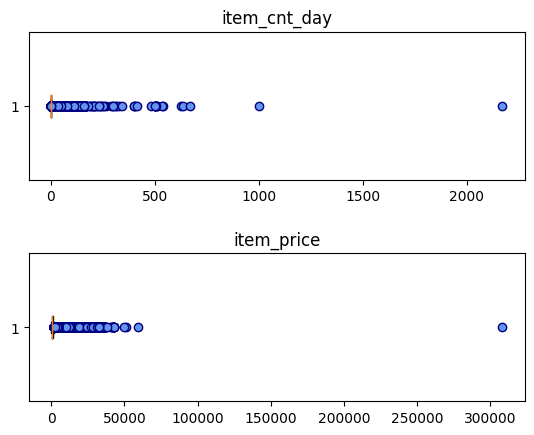

In [ ]:
fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.5)

flierprops = dict(marker='o', markerfacecolor='cornflowerblue', markersize=6, markeredgecolor='navy')

_ = axes[0].boxplot(x=df_train_cleaned.item_cnt_day, flierprops=flierprops, vert=False)
_ = axes[1].boxplot(x=df_train_cleaned.item_price, flierprops=flierprops, vert=False)

_ = axes[0].set_title('item_cnt_day')
_ = axes[1].set_title('item_price')

In [ ]:
df_train_cleaned = df_train_cleaned[(df_train_cleaned.item_price<100000)&(df_train_cleaned.item_price>0)]
df_train_cleaned = df_train_cleaned[(df_train_cleaned.item_cnt_day>0)&(df_train_cleaned.item_cnt_day<1000)]

In [ ]:
df_train_cleaned.shape

(2928483, 7)

### 3. Data exploration

In [ ]:
df_eda = df_train_cleaned.copy()
df_eda.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.00,1.0,37
1,2013-01-03,0,25,2552,899.00,1.0,58
3,2013-01-06,0,25,2554,1709.05,1.0,58
4,2013-01-15,0,25,2555,1099.00,1.0,56
5,2013-01-10,0,25,2564,349.00,1.0,59


+ Having a look at the distribution of item sold per shop


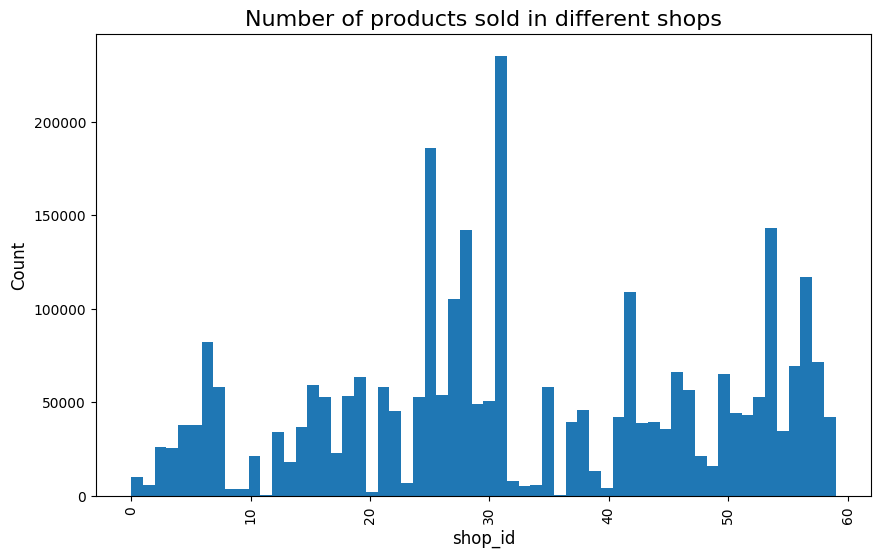

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_eda['shop_id'], bins=len(df_eda['shop_id'].unique()))

# Add a title and labels
plt.title('Number of products sold in different shops', fontsize=16)
plt.xlabel('shop_id', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many shops
plt.show()

+ Having a look at the distribution of item sold per category id

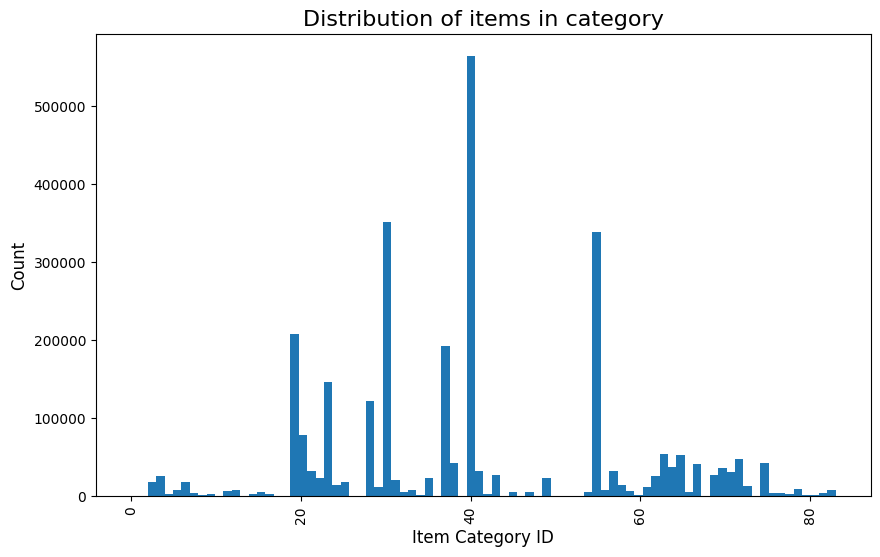

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_eda['item_category_id'], bins=len(df_eda['item_category_id'].unique()))

# Add a title and labels
plt.title('Distribution of items in category', fontsize=16)
plt.xlabel('Item Category ID', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.xticks(rotation=90)
plt.show()

+ Having a look at the distribution of item sold per day

In [ ]:
# plt.rcParams['figure.figsize'] = (19, 9)
# sns.countplot(df_eda['date_block_num'])
# plt.title('Date blocks according to months', fontsize = 30)
# plt.xlabel('Different blocks of months', fontsize = 15)
# plt.ylabel('No. of Purchases', fontsize = 15)
# plt.show()

+ Having a look at the distribution of item price

<ipython-input-29-10a638646dd1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_eda['item_price'], color = 'red')


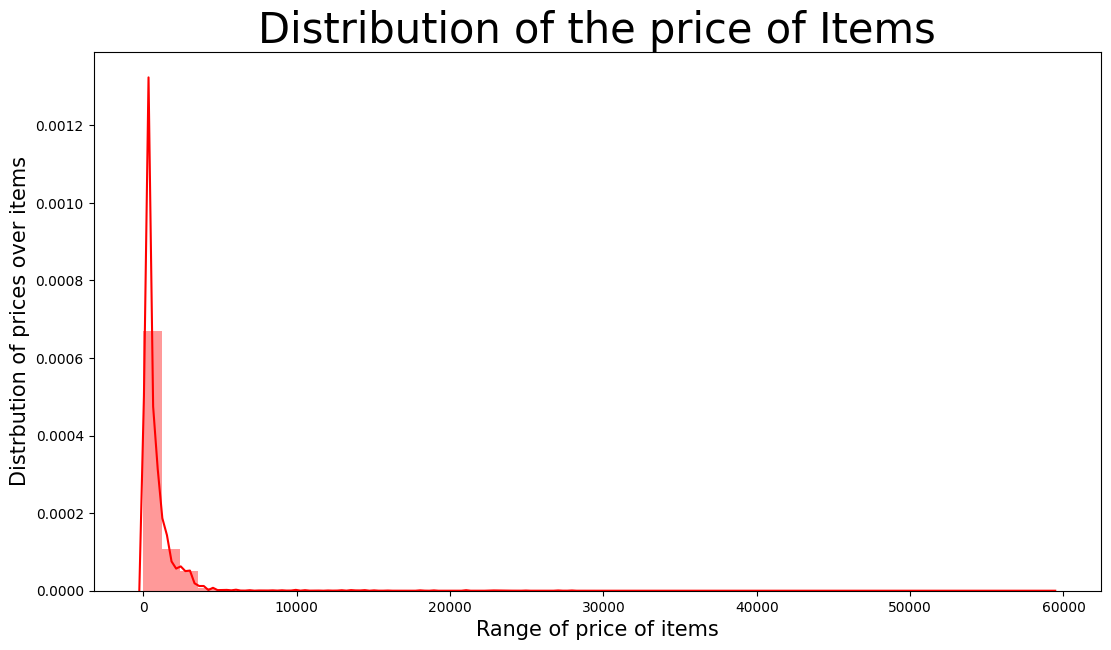

In [ ]:
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(df_eda['item_price'], color = 'red')
plt.title('Distribution of the price of Items', fontsize = 30)
plt.xlabel('Range of price of items', fontsize = 15)
plt.ylabel('Distrbution of prices over items', fontsize = 15)
plt.show()

+ Having a look at the distribution of item sold per day


<ipython-input-30-4871fb64924f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_eda['item_cnt_day'], color = 'purple')


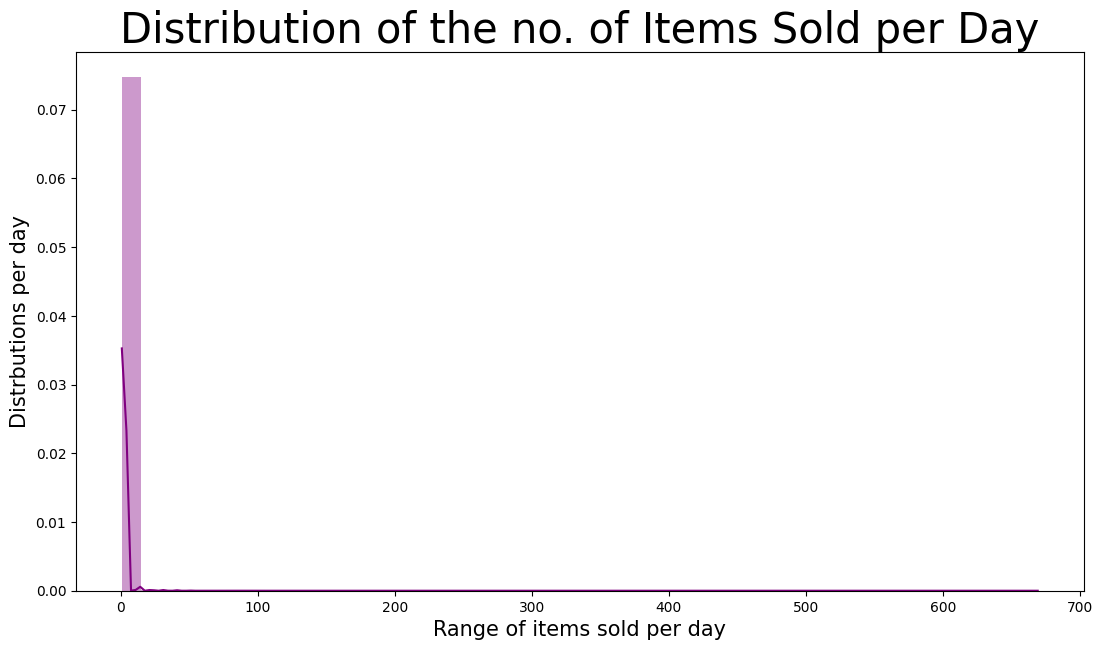

In [ ]:
plt.rcParams['figure.figsize'] = (13, 7)
sns.distplot(df_eda['item_cnt_day'], color = 'purple')
plt.title('Distribution of the no. of Items Sold per Day', fontsize = 30)
plt.xlabel('Range of items sold per day', fontsize = 15)
plt.ylabel('Distrbutions per day', fontsize = 15)
plt.show()

# B. Experiments

### 1. Feature engineering

#### a. Prepare data

In [ ]:
df_engineering = df_train_cleaned.copy()

df_engineering['date'] = df_engineering['date'] .dt.to_period('M').dt.to_timestamp()

df_engineering

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-01,0,59,22154,999.00,1.0,37
1,2013-01-01,0,25,2552,899.00,1.0,58
3,2013-01-01,0,25,2554,1709.05,1.0,58
4,2013-01-01,0,25,2555,1099.00,1.0,56
5,2013-01-01,0,25,2564,349.00,1.0,59
...,...,...,...,...,...,...,...
2935844,2015-10-01,33,25,7409,299.00,1.0,55
2935845,2015-10-01,33,25,7460,299.00,1.0,55
2935846,2015-10-01,33,25,7459,349.00,1.0,55
2935847,2015-10-01,33,25,7440,299.00,1.0,57


+ Compute monthly sales

In [ ]:
monthly_sales_df = df_engineering.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_cnt_day':'sum'})\
          .rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=False)

In [ ]:
monthly_sales_df.columns = ["_".join(pair) if '' not in pair else "".join(pair) for pair in monthly_sales_df.columns]
monthly_sales_df.rename(columns={"item_cnt_month_sum": "monthly_total_sale"}, inplace=True)

+ append test data for preparing

In [ ]:
df_test['date_block_num'] = 34
df_test['item_cnt_month'] = 0
df_test
# del df_test['ID']

,shop_id,item_id,date_block_num,item_cnt_month
0,5,5037,34,0
1,5,5320,34,0
2,5,5233,34,0
3,5,5232,34,0
4,5,5268,34,0
...,...,...,...,...
214195,45,18454,34,0
214196,45,16188,34,0
214197,45,15757,34,0
214198,45,19648,34,0


In [ ]:
monthly_sales_df = pd.concat([monthly_sales_df, df_test]).reset_index(drop=True)
monthly_sales_df

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1822419,34,45,18454,0.0
1822420,34,45,16188,0.0
1822421,34,45,15757,0.0
1822422,34,45,19648,0.0


#### b. Create a feature dataframe
+ Creating a matrix of product for date_block_num, shop_id, item_id

In [50]:
# monthly_sales_df = pd.read_parquet("/content/drive/MyDrive/DATA/ML_test/data/prepared_dataset.parquet")
# monthly_sales_df.drop(columns = "item_category_id", inplace = True)

In [61]:
monthly_sales_df

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1608219,33,59,22087,6
1608220,33,59,22088,2
1608221,33,59,22091,1
1608222,33,59,22100,1


In [40]:
df_date_block_num = pd.DataFrame(monthly_sales_df['date_block_num'].unique(), columns=['date_block_num'], dtype='int16')
df_shop_id = pd.DataFrame(monthly_sales_df['shop_id'].unique(), columns=['shop_id'], dtype='int16')
df_item_id = pd.DataFrame(monthly_sales_df['item_id'].unique(), columns=['item_id'], dtype='int16')

# Create a Cartesian product using pandas' merge
matrix = df_date_block_num.merge(df_shop_id, how='cross').merge(df_item_id, how='cross')

In [62]:
matrix

,date_block_num,shop_id,item_id
0,0,0,32
1,0,0,33
2,0,0,35
3,0,0,43
4,0,0,51
...,...,...,...
44478115,33,36,12733
44478116,33,36,13092
44478117,33,36,16797
44478118,33,36,18060


In [63]:
# Add the features from sales data to the matrix
df = matrix.merge(monthly_sales_df, how='left', on=['date_block_num', 'shop_id', 'item_id']).fillna(0)

In [64]:
df = df.merge(df_items[['item_id','item_category_id']], how='left', on='item_id')

In [65]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57


+ Extract month

In [66]:
df['month'] = df.date_block_num%12

In [67]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,month
0,0,0,32,6.0,40,0
1,0,0,33,3.0,37,0
2,0,0,35,1.0,40,0
3,0,0,43,1.0,40,0
4,0,0,51,2.0,57,0


#### c. Implement feature engineering

+ Lag for total monthly sale for each shop id, item_id, month

In [68]:
def lag_feature(df, lags, col):
  df.sort_values(by=['shop_id', 'item_id', 'date_block_num'], inplace=True)
  for i in lags:
      df[f"{col}_lag_{i}"] = df.groupby(['shop_id', 'item_id'])[col].shift(i).fillna(0)

  return df

In [69]:
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')

+ Lag for total mothly sale for each shop_id, month

In [70]:
# shop/date_block_num aggregates lags
shop_monthly_sales = df.groupby(['shop_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_sale_shop'}, inplace=False)
df = df.merge(shop_monthly_sales, how='left', on=['shop_id', 'date_block_num']).fillna(0)
df = lag_feature(df, [1, 2, 3], 'cnt_sale_shop')
df.drop('cnt_sale_shop', axis=1, inplace=True)

In [71]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,cnt_sale_shop_lag_1,cnt_sale_shop_lag_2,cnt_sale_shop_lag_3
0,0,0,0,0.0,40,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0.0,40,1,0.0,0.0,0.0,5578.0,0.0,0.0
2,2,0,0,0.0,40,2,0.0,0.0,0.0,6127.0,5578.0,0.0
3,3,0,0,0.0,40,3,0.0,0.0,0.0,0.0,6127.0,5578.0
4,4,0,0,0.0,40,4,0.0,0.0,0.0,0.0,0.0,6127.0


+ Lag for total mothly sale for each item, month

In [72]:
# item/date_block_num aggregates lags
items_monthly_sales = df.groupby(['item_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_item'}, inplace=False)
df = df.merge(items_monthly_sales, how='left', on=['item_id', 'date_block_num']).fillna(0)
df = lag_feature(df, [1, 2, 3], 'cnt_block_item')
df.drop('cnt_block_item', axis=1, inplace=True)

In [73]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,cnt_sale_shop_lag_1,cnt_sale_shop_lag_2,cnt_sale_shop_lag_3,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3
0,0,0,0,0.0,40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0.0,40,1,0.0,0.0,0.0,5578.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,0.0,40,2,0.0,0.0,0.0,6127.0,5578.0,0.0,0.0,0.0,0.0
3,3,0,0,0.0,40,3,0.0,0.0,0.0,0.0,6127.0,5578.0,0.0,0.0,0.0
4,4,0,0,0.0,40,4,0.0,0.0,0.0,0.0,0.0,6127.0,0.0,0.0,0.0


+ Lag for total mothly sale for each item_category, month

In [74]:
# category/date_block_num aggregates lags
items_cat_monthly_sales = df.groupby(['item_category_id', 'date_block_num'],as_index=False)\
          .agg({'item_cnt_month':'sum'})\
          .rename(columns={'item_cnt_month':'cnt_block_category'}, inplace=False)
df = df.merge(items_cat_monthly_sales, how='left', on=['item_category_id', 'date_block_num']).fillna(0)
df = lag_feature(df, [1, 2, 3], 'cnt_block_category')
df.drop('cnt_block_category', axis=1, inplace=True)

In [75]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,cnt_sale_shop_lag_1,cnt_sale_shop_lag_2,cnt_sale_shop_lag_3,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3
0,0,0,0,0.0,40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0.0,40,1,0.0,0.0,0.0,5578.0,0.0,0.0,0.0,0.0,0.0,33531.0,0.0,0.0
2,2,0,0,0.0,40,2,0.0,0.0,0.0,6127.0,5578.0,0.0,0.0,0.0,0.0,31681.0,33531.0,0.0
3,3,0,0,0.0,40,3,0.0,0.0,0.0,0.0,6127.0,5578.0,0.0,0.0,0.0,36311.0,31681.0,33531.0
4,4,0,0,0.0,40,4,0.0,0.0,0.0,0.0,0.0,6127.0,0.0,0.0,0.0,27563.0,36311.0,31681.0


In [76]:
print('{0:.2f}'.format(df.memory_usage(index=False, deep=True).sum()/(2**20)), 'MB')

5090.12 MB


In [80]:
df.dtypes

,0
date_block_num,int32
shop_id,int32
item_id,int32
item_cnt_month,int32
item_category_id,int32
month,int32
item_cnt_month_lag_1,int32
item_cnt_month_lag_2,int32
item_cnt_month_lag_3,int32
cnt_sale_shop_lag_1,int32


In [79]:
print('{0:.2f}'.format(df.memory_usage(index=False, deep=True).sum()/(2**20)), 'MB')

3054.07 MB


#### c. Convert to category type

In [81]:
category_types = ["shop_id", "item_id", "month", "item_category_id", "date_block_num"]
int16_types = ["item_cnt_month", "item_cnt_month_lag_1", "item_cnt_month_lag_2", "item_cnt_month_lag_3"]
int32_types = ["cnt_sale_shop_lag_1", "cnt_sale_shop_lag_2", "cnt_sale_shop_lag_3", "cnt_block_item_lag_1", "cnt_block_item_lag_2", "cnt_block_item_lag_3", "cnt_block_category_lag_1", "cnt_block_category_lag_2", "cnt_block_category_lag_3"]

type_dict = {
    'category': category_types,
    'int16': int16_types,
    'int32': int32_types
}

for key, types in type_dict.items():
  df[types] = df[types].astype(key)

In [82]:
df.dtypes

,0
date_block_num,category
shop_id,category
item_id,category
item_cnt_month,int16
item_category_id,category
month,category
item_cnt_month_lag_1,int16
item_cnt_month_lag_2,int16
item_cnt_month_lag_3,int16
cnt_sale_shop_lag_1,int32


In [83]:
print('{0:.2f}'.format(df.memory_usage(index=False, deep=True).sum()/(2**20)), 'MB')

2121.35 MB


In [84]:
df.describe()

,item_cnt_month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,cnt_sale_shop_lag_1,cnt_sale_shop_lag_2,cnt_sale_shop_lag_3,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3
count,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07,4.447812e+07
mean,8.212060e-02,8.056894e-02,7.892793e-02,7.743965e-02,1.756645e+03,1.720866e+03,1.688417e+03,4.834136e+00,4.735676e+00,4.646379e+00,6.991426e+03,6.902128e+03,6.795592e+03
std,1.658636e+00,1.646800e+00,1.575159e+00,1.567411e+00,1.943985e+03,1.946700e+03,1.955904e+03,5.395506e+01,5.357382e+01,5.335536e+01,8.370522e+03,8.416045e+03,8.460459e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.195000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.550000e+02,4.890000e+02,3.890000e+02
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.372000e+03,1.350500e+03,1.324500e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.236000e+03,2.506000e+03,2.067000e+03
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.218500e+03,2.181250e+03,2.167000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.149900e+04,1.149900e+04,1.149900e+04
max,1.644000e+03,1.644000e+03,1.305000e+03,1.305000e+03,1.633800e+04,1.633800e+04,1.633800e+04,1.255700e+04,1.255700e+04,1.255700e+04,3.631100e+04,3.631100e+04,3.631100e+04


In [86]:
# df.to_parquet("/content/drive/MyDrive/DATA/ML_test/data/engineered_dataset.parquet")

### 2. Train test valid split

+ Get 3 last month data for evaluation and remaining data for training

In [3]:
# df = pd.read_parquet("/content/drive/MyDrive/DATA/ML_test/data/engineered_dataset.parquet")

In [4]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,cnt_sale_shop_lag_1,cnt_sale_shop_lag_2,cnt_sale_shop_lag_3,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3
0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,40,1,0,0,0,5578,0,0,0,0,0,33531,0,0
2,2,0,0,0,40,2,0,0,0,6127,5578,0,0,0,0,31681,33531,0
3,3,0,0,0,40,3,0,0,0,0,6127,5578,0,0,0,36311,31681,33531
4,4,0,0,0,40,4,0,0,0,0,0,6127,0,0,0,27563,36311,31681


In [5]:
X_train = df[df.date_block_num < 31].drop(['item_cnt_month'], axis=1)
y_train = df[df.date_block_num < 31]['item_cnt_month']
X_val = df[df.date_block_num.between(31, 33)].drop(['item_cnt_month'], axis=1)
y_val =  df[df.date_block_num.between(31, 33)]['item_cnt_month']
X_test = df[df.date_block_num==34].drop(['item_cnt_month'], axis=1)

In [6]:
# X_test.to_parquet("/content/drive/MyDrive/DATA/ML_test/data/test_34_dataset.parquet")

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (40553580, 17)
X_val shape: (3924540, 17)


In [7]:
X_train.drop('date_block_num', axis=1, inplace=True)
X_val.drop('date_block_num', axis=1, inplace=True)

### 3. Built baseline model
+ Using Target encoding for High Cardinality columns

#### Built pipeline

In [32]:
TE_COLS = ["item_id"]
high_cardinality_hparams = dict(
    min_frequency=10,  # TODO: add this to hyperparam tuning
    high_cardinality_cols=TE_COLS,
)

target_encoding_pipe = Pipeline(
    steps=[
        ("target_encode", TargetEncoder())
    ]
)

preprocesser = ColumnTransformer(
        transformers=[
            ("target_encoding", target_encoding_pipe, TE_COLS),
        ],
        remainder="passthrough",
)

In [52]:
model_parameters = {
  "tree_method" : "gpu_hist",
  'objective': 'reg:squarederror', # regression task
  'n_estimators': 100,
  'max_depth': 5,
  'eval_metric': 'rmse',
  'learning_rate': 0.1,
  'early_stopping_rounds': 10
}

In [33]:
valid_preprocesser = preprocesser.fit(X_train, y_train)
X_valid_transformed = valid_preprocesser.transform(X_val)
X_train_transformed = valid_preprocesser.transform(X_train)
print(f"X_valid shape: {X_val.shape}")
print(f"X_valid_transformed shape: {X_valid_transformed.shape}")

X_valid shape: (3924540, 16)
X_valid_transformed shape: (3924540, 16)


In [50]:
xgb_model = XGBRegressor(**model_parameters)
pipeline = Pipeline(
    steps=[("preprocesser", preprocesser), ("train_model", xgb_model)]
)

#### Training

In [53]:
# todo check again these model code
print("Fit model")
pipeline.fit(
    X_train,
    y_train,
    train_model__eval_set=[
        (X_train_transformed, y_train),
        (X_valid_transformed, y_val),
    ],
)

Fit model


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:41:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.55882	validation_1-rmse:1.78722
[1]	validation_0-rmse:1.48781	validation_1-rmse:1.75539
[2]	validation_0-rmse:1.42708	validation_1-rmse:1.72833
[3]	validation_0-rmse:1.37469	validation_1-rmse:1.70374
[4]	validation_0-rmse:1.33037	validation_1-rmse:1.68706
[5]	validation_0-rmse:1.29179	validation_1-rmse:1.67039
[6]	validation_0-rmse:1.25947	validation_1-rmse:1.65529
[7]	validation_0-rmse:1.23187	validation_1-rmse:1.64286
[8]	validation_0-rmse:1.20673	validation_1-rmse:1.63179
[9]	validation_0-rmse:1.18462	validation_1-rmse:1.62539
[10]	validation_0-rmse:1.16598	validation_1-rmse:1.61732
[11]	validation_0-rmse:1.14926	validation_1-rmse:1.61491
[12]	validation_0-rmse:1.13484	validation_1-rmse:1.61267
[13]	validation_0-rmse:1.12228	validation_1-rmse:1.60916
[14]	validation_0-rmse:1.11287	validation_1-rmse:1.60640
[15]	validation_0-rmse:1.10342	validation_1-rmse:1.60447
[16]	validation_0-rmse:1.09486	validation_1-rmse:1.60283
[17]	validation_0-rmse:1.08789	validation

Pipeline(steps=[('preprocesser',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encoding',
                                                  Pipeline(steps=[('target_encode',
                                                                   TargetEncoder())]),
                                                  ['item_id'])])),
                ('train_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=No...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### Note: This model is facing with over fitting problems, need to enhance more, I don't have much time to spend on optimizing so i skip it now for implementing deployment phase

#### Feature importance

In [13]:
def visualize_feat_important_builtin_xgboost(pipeline, feature_names_out):
    TITLE = "Feature Importance with Built-in XGboost"
    sorted_idx = pipeline[-1].feature_importances_.argsort()
    fig, ax = plt.subplots(figsize=(10, 14))
    plt.barh(
        feature_names_out[sorted_idx], pipeline[-1].feature_importances_[sorted_idx]
    )
    ax.set_title(TITLE)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:51:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


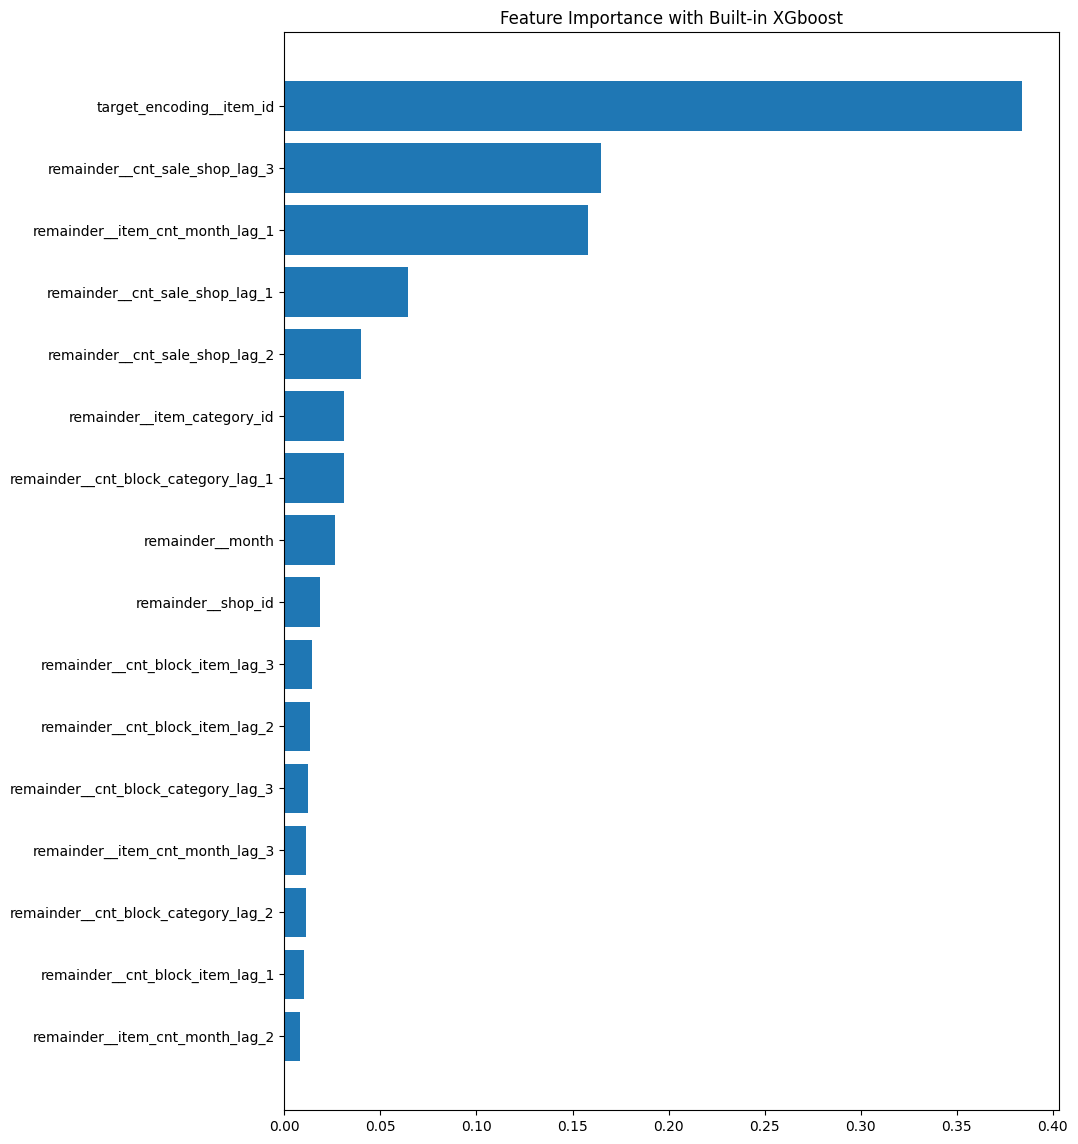

In [14]:
feature_names_out = pipeline.named_steps["preprocesser"].get_feature_names_out()
visualize_feat_important_builtin_xgboost(pipeline, feature_names_out)

#### Error analysis (Do it later)

### 4. Evaluate model stabability

In [19]:
# df[df.date_block_num < 31].drop(['item_cnt_month'], axis=1)["date_block_num"].value_counts()

In [39]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

tscv = TimeSeriesSplit(n_splits=3, test_size=1308180)
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[       0        1        2 ... 36629037 36629038 36629039]
  Test:  index=[36629040 36629041 36629042 ... 37937217 37937218 37937219]
Fold 1:
  Train: index=[       0        1        2 ... 37937217 37937218 37937219]
  Test:  index=[37937220 37937221 37937222 ... 39245397 39245398 39245399]
Fold 2:
  Train: index=[       0        1        2 ... 39245397 39245398 39245399]
  Test:  index=[39245400 39245401 39245402 ... 40553577 40553578 40553579]


In [ ]:
model_parameters = {
  "tree_method" : "gpu_hist",
  'objective': 'reg:squarederror', # regression task
  'n_estimators': 100,
  'max_depth': 5,
  'eval_metric': 'rmse',
  'learning_rate': 0.1
}
xgb_model = XGBRegressor(**model_parameters)
pipeline = Pipeline(
    steps=[("preprocesser", preprocesser), ("train_model", xgb_model)]
)
scores = cross_validate(pipeline, X_train, y_train, cv=tscv, scoring="neg_root_mean_squared_error", return_estimator=True)

In [47]:
# RMSE on each testing fold by time
abs(scores["test_score"])

array([2.56217432, 1.17477047, 0.65490729])

#### Conclusion: Model is high over- fitting need to enhance further.

### 5. Saving prepare data and model

In [55]:
joblib.dump(pipeline, "model.joblib")

['model.joblib']